In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from ucimlrepo import fetch_ucirepo

In [5]:
communities_and_crime = fetch_ucirepo(id=183) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 

### Data Preprocessing

In [8]:
#find columns with '?' values
na_columns = X.loc[:, X.isin(["?"]).any()]

In [10]:
#find number of na values in each columns with '?' values
for col in na_columns:
    occurenace = na_columns[col].value_counts().get('?', 0)
    print(col, "has", occurenace, "na values")

county has 1174 na values
community has 1177 na values
OtherPerCap has 1 na values
LemasSwornFT has 1675 na values
LemasSwFTPerPop has 1675 na values
LemasSwFTFieldOps has 1675 na values
LemasSwFTFieldPerPop has 1675 na values
LemasTotalReq has 1675 na values
LemasTotReqPerPop has 1675 na values
PolicReqPerOffic has 1675 na values
PolicPerPop has 1675 na values
RacialMatchCommPol has 1675 na values
PctPolicWhite has 1675 na values
PctPolicBlack has 1675 na values
PctPolicHisp has 1675 na values
PctPolicAsian has 1675 na values
PctPolicMinor has 1675 na values
OfficAssgnDrugUnits has 1675 na values
NumKindsDrugsSeiz has 1675 na values
PolicAveOTWorked has 1675 na values
PolicCars has 1675 na values
PolicOperBudg has 1675 na values
LemasPctPolicOnPatr has 1675 na values
LemasGangUnitDeploy has 1675 na values
PolicBudgPerPop has 1675 na values


In [12]:
#Only 'OtherPerCap' col has one na value, so it is not relevant to remove the whole column.
#So, I will impute missing value with the median for just'OtherPerCap' . 
X['OtherPerCap'] = pd.to_numeric(X['OtherPerCap'].replace('?', np.nan), errors='coerce')

median_OtherPerCap = X['OtherPerCap'].median()
X['OtherPerCap'].fillna(median_OtherPerCap, inplace=True)

In [14]:
#remove na_columns from original datasets and keep 'OtherPerCap' in X
X = X.drop(na_columns, axis=1)
na_columns = na_columns.drop('OtherPerCap', axis=1)

In [16]:
# Check datatype of columns in X 
#'state', 'communityname', and 'fold' are non float datatypes, so remove these columns.
for col in X:
    print(col, "has", X[col].dtypes, "types")

X = X.drop("communityname", axis=1)
X = X.drop("state", axis=1)
X = X.drop("fold", axis=1)

state has int64 types
communityname has object types
fold has int64 types
population has float64 types
householdsize has float64 types
racepctblack has float64 types
racePctWhite has float64 types
racePctAsian has float64 types
racePctHisp has float64 types
agePct12t21 has float64 types
agePct12t29 has float64 types
agePct16t24 has float64 types
agePct65up has float64 types
numbUrban has float64 types
pctUrban has float64 types
medIncome has float64 types
pctWWage has float64 types
pctWFarmSelf has float64 types
pctWInvInc has float64 types
pctWSocSec has float64 types
pctWPubAsst has float64 types
pctWRetire has float64 types
medFamInc has float64 types
perCapInc has float64 types
whitePerCap has float64 types
blackPerCap has float64 types
indianPerCap has float64 types
AsianPerCap has float64 types
HispPerCap has float64 types
NumUnderPov has float64 types
PctPopUnderPov has float64 types
PctLess9thGrade has float64 types
PctNotHSGrad has float64 types
PctBSorMore has float64 types
P

To recap data cleaning, I found columns with '?' values and checked their datatypes. Since they are all object datatypes and contained over 1000 na values except 'OtherPerCap', I removed all columns with '?' values and kept 'OtherPerCap' column by imputing the '?' with median value. Then, I checked the datatypes of the rest of columns in X. 'state', 'fold', and 'communityname' are non float datatypes, so I dropped those three columns.

## #2 a)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error 

y = y.values.ravel()
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

In [22]:
#from lab7
#Generates a RBF Gaussian kernel from training data X
def gaussian_kernel(X_1: np.ndarray, X_2: np.ndarray, gamma: float = 1.0):
    pairwise = np.sum(X_1**2, axis=1).reshape(-1,1) + np.sum(X_2**2, axis=1)-2 * np.dot(X_1,X_2.T)
    return np.exp(-gamma * pairwise)

#Generates a simple polynomial kernel from training data X
def polynomial_kernel(X_1: np.ndarray, X_2: np.ndarray, d: int, r: float = 1.0, gamma: float = 1.0):
    return (r + gamma * np.dot(X_1, X_2.T)) ** d

#Kernel ridge regression function
def kernel_ridge_regression(K: np.ndarray, y: np.ndarray, lambd: float):
    n = K.shape[0]
    return np.linalg.solve(K+lambd*np.eye(n),y)

In [24]:
def cross_val_kernel_ridge(X_data: np.ndarray, y_data: np.ndarray, num_folds: int, kernel_name: str, kernel_vals: list, reg_params: list):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    cv_results = {'reg_param': [], 'kernel_val': [], 'mean_mse': []}
    
    for reg_param in reg_params:
        for kernel_val in kernel_vals:
            mse_scores = []
            
            for train_indices, val_indices in kfold.split(X_data):
                X_train, X_valid = X_data[train_indices], X_data[val_indices]
                y_train, y_valid = y_data[train_indices], y_data[val_indices]
                
                # Compute kernel matrices
                if kernel_name == 'rbf':
                    K_train = gaussian_kernel(X_train, X_train, gamma=kernel_val)
                    K_valid = gaussian_kernel(X_valid, X_train, gamma=kernel_val)
                elif kernel_name == 'poly':
                    K_train = polynomial_kernel(X_train, X_train, d=kernel_val)
                    K_valid = polynomial_kernel(X_valid, X_train, d=kernel_val)
                
                # Train using Kernel Ridge Regression
                alpha_coeffs = kernel_ridge_regression(K_train, y_train, reg_param)
                
                # Predict and compute MSE
                y_predictions = np.dot(K_valid, alpha_coeffs)
                mse_scores.append(mean_squared_error(y_valid, y_predictions))
            
            # Store results
            cv_results['reg_param'].append(reg_param)
            cv_results['kernel_val'].append(kernel_val)
            cv_results['mean_mse'].append(np.mean(mse_scores))
    
    return cv_results

## b)

In [36]:
gammas = [0.001, 0.01, 0.1, 1, 10]  
lambdas = [0.001, 0.01, 0.1, 1, 10] 
degrees = [2, 3, 4, 5, 6]  

# RBF kernel
results_rbf = cross_val_kernel_ridge(X_standardized, y, num_folds=5, kernel_name='rbf', kernel_vals=gammas, reg_params=lambdas)

# polynomial kernel
results_poly = cross_val_kernel_ridge(X_standardized, y, num_folds=5, kernel_name='poly', kernel_vals=degrees, reg_params=lambdas)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [38]:
best_idx_rbf = np.argmin(results_rbf['mean_mse'])
best_lambda_rbf = results_rbf['reg_param'][best_idx_rbf]
best_gamma_rbf = results_rbf['kernel_val'][best_idx_rbf]
best_mse_rbf = results_rbf['mean_mse'][best_idx_rbf]

best_idx_poly = np.argmin(results_poly['mean_mse'])
best_lambda_poly = results_poly['reg_param'][best_idx_poly]
best_degree_poly = results_poly['kernel_val'][best_idx_poly]
best_mse_poly = results_poly['mean_mse'][best_idx_poly]

print(f"Best RBF Kernel: gamma={best_gamma_rbf}, lambda={best_lambda_rbf}, MSE={best_mse_rbf}")
print(f"Best Polynomial Kernel: degree={best_degree_poly}, lambda={best_lambda_poly}, MSE={best_mse_poly}")

Best RBF Kernel: gamma=0.001, lambda=0.1, MSE=0.017821125476743072
Best Polynomial Kernel: degree=2, lambda=10, MSE=0.07207397797866742


## Running with Sklearn

In [43]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

In [47]:
param_grid_rbf = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],  
    'gamma': [0.001, 0.01, 0.1, 1]  
}

param_grid_poly = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'degree': [2, 3, 4, 5, 6]  
}

kr_rbf = KernelRidge(kernel='rbf')
gscv_rbf = GridSearchCV(kr_rbf, param_grid_rbf, cv=5, scoring='neg_mean_squared_error')
gscv_rbf.fit(X_standardized, y)

kr_poly = KernelRidge(kernel='poly')
gscv_poly = GridSearchCV(kr_poly, param_grid_poly, cv=5, scoring='neg_mean_squared_error')
gscv_poly.fit(X_standardized, y)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


GridSearchCV(cv=5, estimator=KernelRidge(kernel='poly'),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'degree': [2, 3, 4, 5, 6]},
             scoring='neg_mean_squared_error')

In [49]:
best_rbf_params = gscv_rbf.best_params_
best_poly_params = gscv_poly.best_params_
best_mse_rbf = -gscv_rbf.best_score_
best_mse_poly = -gscv_poly.best_score_

print("Best RBF Kernel (sklearn):", best_rbf_params, "MSE:", best_mse_rbf)
print("Best Polynomial Kernel (sklearn):", best_poly_params, "MSE:", best_mse_poly)

Best RBF Kernel (sklearn): {'alpha': 0.1, 'gamma': 0.001} MSE: 0.017709797036128978
Best Polynomial Kernel (sklearn): {'alpha': 10, 'degree': 3} MSE: 0.01790170219061269


# #3

In [52]:
import struct
from array import array
from os.path  import join

In [54]:
#from kaggle, loading data
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())     

        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

In [56]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

input_path = '/Users/kei/Desktop/Spring2025/Statistical Machine Learning/HW2/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [58]:
#from kaggle, displaying images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
        
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# a)

In [65]:
#filter dataset to 3, 5, 8
digits = [3, 5, 8]
train_mask = np.isin(y_train, digits)
test_mask = np.isin(y_test, digits)

In [67]:
#using masks to select 3,5,8 from training and testing set.
X_train, Y_train = np.array(x_train)[train_mask], np.array(y_train)[train_mask]
X_test, Y_test = np.array(x_test)[test_mask], np.array(y_test)[test_mask]

#flatten each sample into a 1D vector
X_train = X_train.reshape(X_train.shape[0], -1)  
X_test = X_test.reshape(X_test.shape[0], -1)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression (OvR)": LogisticRegression(multi_class='ovr', max_iter=1000),
    "Multinomial Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Linear SVM (OvR)": LinearSVC(multi_class='ovr', max_iter=10000)
}

In [73]:
def show_images(images, titles, n_rows, n_cols, fontsize=10):
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i], fontsize=8)  
        plt.axis('off')
    plt.tight_layout()
    plt.show()


=== Logistic Regression (OvR) ===
Accuracy: 0.9256

Classification Report:
              precision    recall  f1-score   support

           3       0.94      0.94      0.94      1010
           5       0.92      0.90      0.91       892
           8       0.91      0.93      0.92       974

    accuracy                           0.93      2876
   macro avg       0.93      0.92      0.93      2876
weighted avg       0.93      0.93      0.93      2876


Confusion Matrix:
[[947  29  34]
 [ 34 806  52]
 [ 28  37 909]]


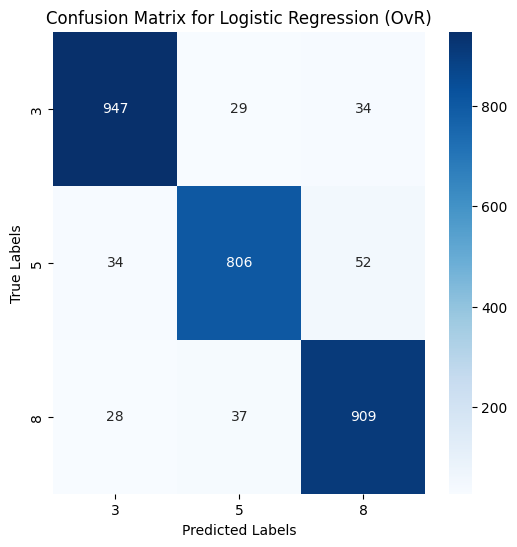

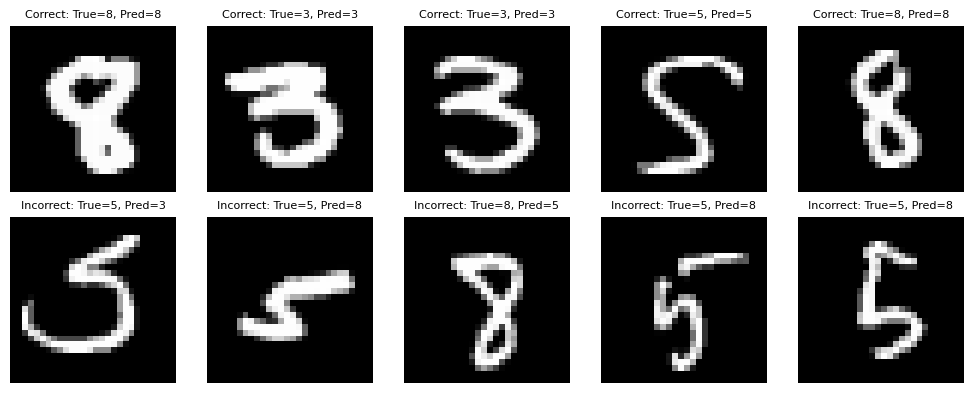


=== Multinomial Logistic Regression ===
Accuracy: 0.9221

Classification Report:
              precision    recall  f1-score   support

           3       0.93      0.94      0.93      1010
           5       0.92      0.90      0.91       892
           8       0.92      0.93      0.92       974

    accuracy                           0.92      2876
   macro avg       0.92      0.92      0.92      2876
weighted avg       0.92      0.92      0.92      2876


Confusion Matrix:
[[946  29  35]
 [ 41 803  48]
 [ 32  39 903]]


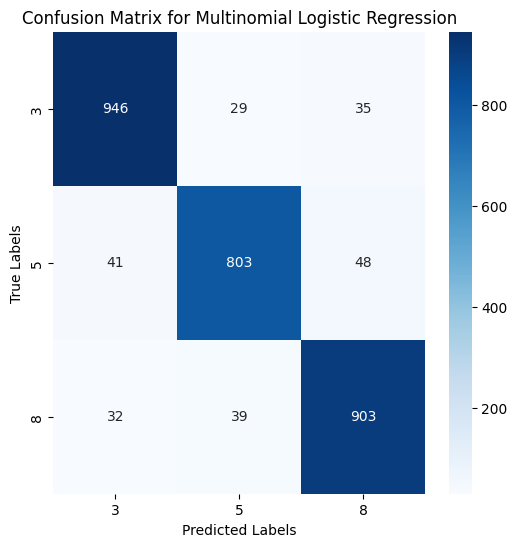

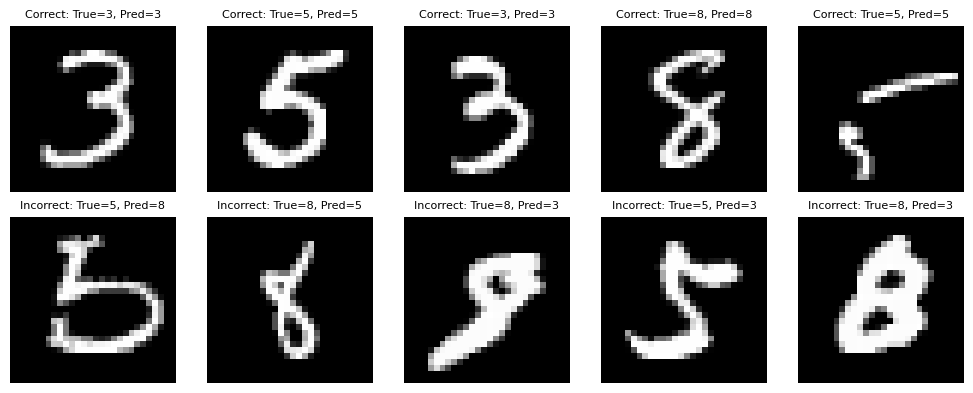


=== Gaussian Naive Bayes ===
Accuracy: 0.5035

Classification Report:
              precision    recall  f1-score   support

           3       0.87      0.42      0.56      1010
           5       0.72      0.10      0.18       892
           8       0.41      0.96      0.58       974

    accuracy                           0.50      2876
   macro avg       0.67      0.49      0.44      2876
weighted avg       0.67      0.50      0.45      2876


Confusion Matrix:
[[422  16 572]
 [ 45  90 757]
 [ 19  19 936]]


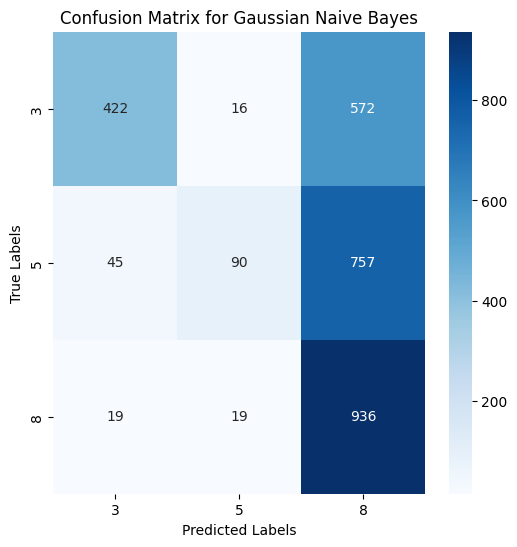

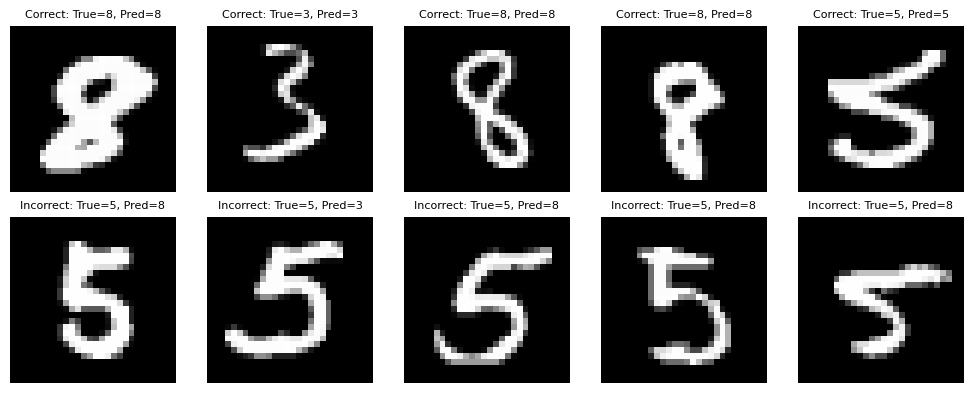


=== Linear Discriminant Analysis ===
Accuracy: 0.9200

Classification Report:
              precision    recall  f1-score   support

           3       0.94      0.92      0.93      1010
           5       0.89      0.92      0.91       892
           8       0.93      0.91      0.92       974

    accuracy                           0.92      2876
   macro avg       0.92      0.92      0.92      2876
weighted avg       0.92      0.92      0.92      2876


Confusion Matrix:
[[933  43  34]
 [ 33 823  36]
 [ 30  54 890]]


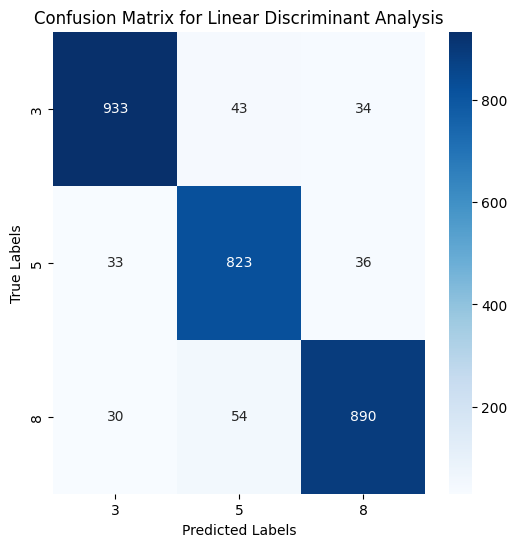

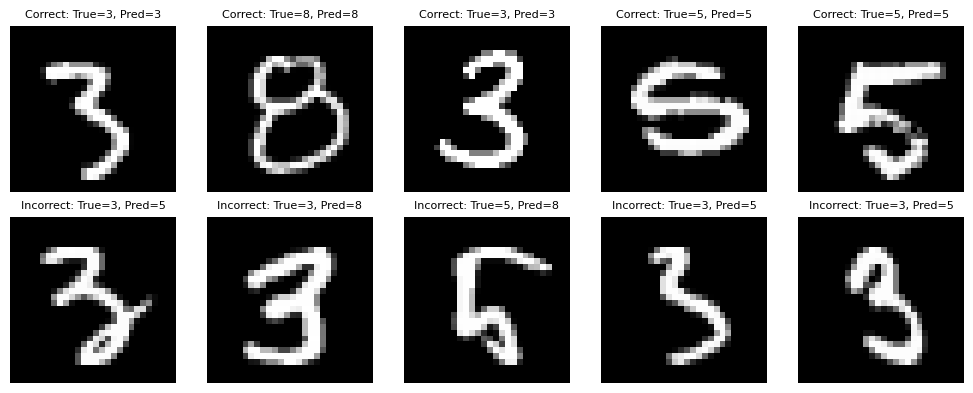


=== Linear SVM (OvR) ===
Accuracy: 0.8814

Classification Report:
              precision    recall  f1-score   support

           3       0.83      0.97      0.89      1010
           5       0.89      0.89      0.89       892
           8       0.95      0.78      0.86       974

    accuracy                           0.88      2876
   macro avg       0.89      0.88      0.88      2876
weighted avg       0.89      0.88      0.88      2876


Confusion Matrix:
[[979  20  11]
 [ 68 798  26]
 [139  77 758]]


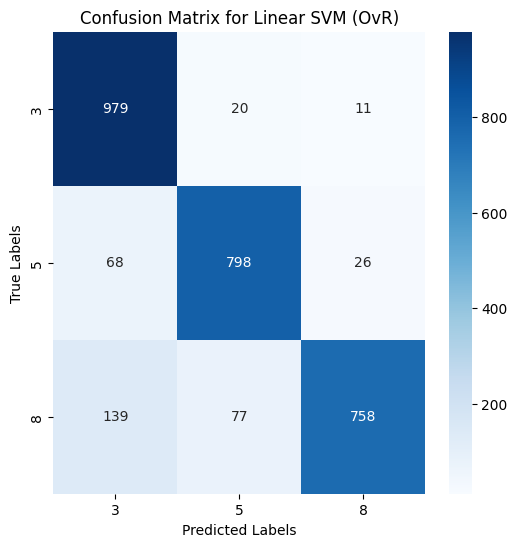

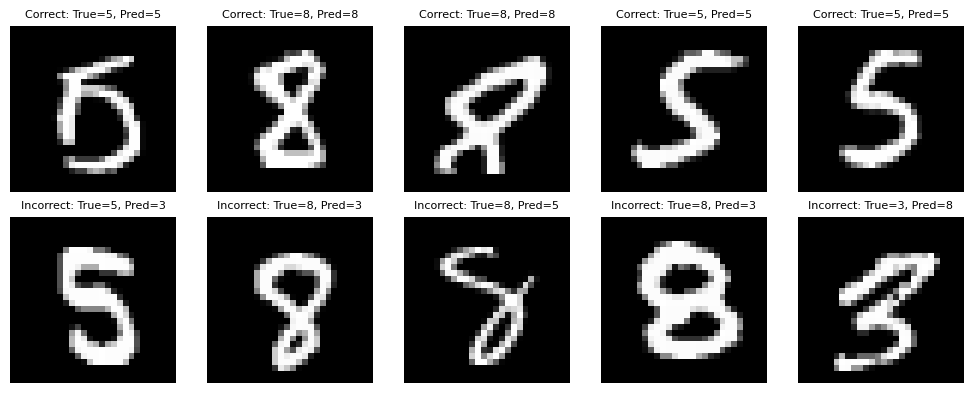

In [75]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")

    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred, target_names=[str(d) for d in digits]))

    conf_matrix = confusion_matrix(Y_test, Y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=digits, yticklabels=digits)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Find correctly and incorrectly classified images
    correct_indices = []
    incorrect_indices = []

    for i in range(len(Y_test)):
        if Y_test[i] == Y_pred[i]:
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)

    num_samples = 5  # Number of samples to display for each case

    # Ensure we don't sample more than available
    num_correct_samples = min(num_samples, len(correct_indices))
    num_incorrect_samples = min(num_samples, len(incorrect_indices))

    # Randomly select some correctly and incorrectly classified images
    correct_samples = random.sample(correct_indices, num_correct_samples)
    incorrect_samples = random.sample(incorrect_indices, num_incorrect_samples)
    
    images_2_show = []
    titles_2_show = []

    # add correctly classified images
    for i in correct_samples:
        images_2_show.append(X_test[i].reshape(28, 28))  
        titles_2_show.append(f'Correct: True={Y_test[i]}, Pred={Y_pred[i]}')

    # Add incorrectly classified images
    for i in incorrect_samples:
        images_2_show.append(X_test[i].reshape(28, 28)) 
        titles_2_show.append(f'Incorrect: True={Y_test[i]}, Pred={Y_pred[i]}')

    show_images(images_2_show, titles_2_show, n_rows=2, n_cols=max(num_correct_samples, num_incorrect_samples), fontsize=8)

## Regularization

In [77]:
pip install group_lasso

Note: you may need to restart the kernel to use updated packages.


In [79]:
from group_lasso import GroupLasso

In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

groups = np.arange(X_train_scaled.shape[1])

group_lasso_model = GroupLasso(groups=groups, group_reg=0.1, l1_reg=0, supress_warning=True, n_iter=1000, tol=1e-4)

group_lasso_model.fit(X_train_scaled, Y_train)

selected_features = group_lasso_model.sparsity_mask_


Selected feature indices: [149 150 175 176 268 288 289 290 291 295 296 316 317 318 319 434 461 462
 466 467 485 486 487 488 489 494 513 514 515 516 522 543 564 577]
Number of selected features: 34


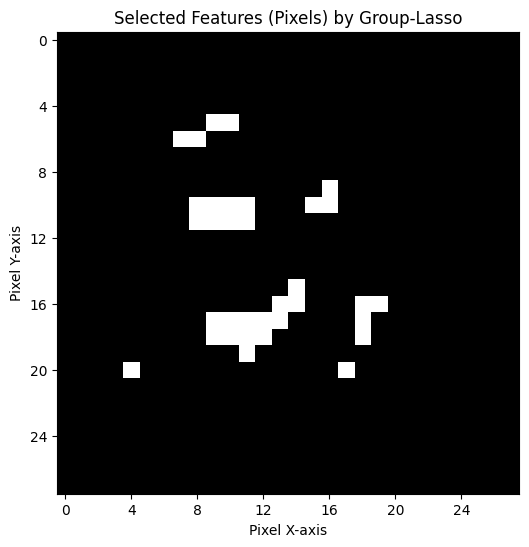

In [124]:
selected_feature_indices = np.where(selected_features)[0]
print(f"\nSelected feature indices: {selected_feature_indices}")
print(f"Number of selected features: {len(selected_feature_indices)}")

plt.figure(figsize=(6, 6))
plt.imshow(selected_features_image, cmap='gray')
plt.title("Selected Features (Pixels) by Group-Lasso")
plt.xlabel("Pixel X-axis")
plt.ylabel("Pixel Y-axis")

plt.xticks(range(0, 28, 4)) 
plt.yticks(range(0, 28, 4))
plt.show()